In [1]:
from __future__ import print_function
from __future__ import division

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
assert torch.cuda.is_available(), 'GPU unavailable'

In [3]:
def get_data_loaders():
  loader_kwargs = {
    'batch_size': 100,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }
  
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
  ])
  
  CIFAR10_train = CIFAR10(root='.', train=True, transform=transform, download=True)
  CIFAR10_test = CIFAR10(root='.', train=False, transform=transform, download=True)
  
  train_set, val_set = random_split(CIFAR10_train, [40000, 10000],
                                    generator=torch.Generator().manual_seed(0))
  
  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)
  test_loader = DataLoader(CIFAR10_test, **loader_kwargs)
  
  return train_loader, val_loader, test_loader

**Resnet34 Model**

In [4]:
#In this Part, resnet_block is a basic resnet block, we choose resnet, because we believe deeper layer may potentially maintain more features of the image and cause less overfitting than we thought.
# RELU, ELU, and GELU are tested before final decision. The ELU function works much better than the other two.
# p=0.2 is used in dropout layer because we have tested that p=0.1 gives the best result.

class resnet_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(resnet_block, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.act = nn.ELU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, ipt):
    residual = ipt
    out = self.conv1(ipt)
    out = self.bn1(out)
    out = self.act(out)
    out = self.dropout(out)
        
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample is not None:
      residual = self.downsample(ipt)
    out += residual
    out = self.act(out)
    out = self.dropout(out)
    return out


class Net(nn.Module):
  
  def __init__(self):
    super().__init__()
    # Before implement resnet block
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.act = nn.ELU(inplace=True)
    
    # ResNet layers
    downsample = None
    # Perform 34-layer resnet, using number of resblock in each layer is [3,4,6,3]
    # number of output channels in year layer should follow 64,128,256,512
    # List of each type of resnet can be found in https://datagen.tech/guides/computer-vision/resnet-50/#:~:text=ResNet%2D50%20is%20a%2050,networks%20by%20stacking%20residual%20blocks.
    self.layer1 = nn.Sequential(resnet_block(64, 64, stride=1, downsample=downsample),*[resnet_block(64, 64) for _ in range(1, 3)])
    downsample = nn.Sequential(nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),nn.BatchNorm2d(128))
    self.layer2 = nn.Sequential(resnet_block(64, 128, stride=2, downsample=downsample),*[resnet_block(128, 128) for _ in range(1, 4)])
    downsample = nn.Sequential(nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),nn.BatchNorm2d(256))
    self.layer3 = nn.Sequential(resnet_block(128, 256, stride=2, downsample=downsample),*[resnet_block(256, 256) for _ in range(1, 6)])
    downsample = nn.Sequential(nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),nn.BatchNorm2d(512))
    self.layer4 = nn.Sequential(resnet_block(256, 512, stride=2, downsample=downsample),*[resnet_block(512, 512) for _ in range(1, 3)])
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling, typically use (1,1)
    
    self.fc = nn.Linear(512, 10)
    self.dropout = nn.Dropout(p=0.1)
  
  
  def forward(self, images, labels):
    loss = None
    y = self.conv1(images)
    y = self.bn1(y)
    y = self.act(y)
    y = self.dropout(y)
    y = self.layer1(y)
    y = self.layer2(y)
    y = self.layer3(y)
    y = self.layer4(y)
    y = self.avgpool(y)
    y = y.view(y.size(0), -1)
    y = self.fc(y)
    loss = F.cross_entropy(y, labels)
    return loss
  
  
  def predict(self, images):
    labels_pred = None
    outp = self.conv1(images)
    outp = self.bn1(outp)
    outp = self.act(outp)
    outp = self.dropout(outp)
    outp = self.layer1(outp)
    outp = self.layer2(outp)
    outp = self.layer3(outp)
    outp = self.layer4(outp)
    outp = self.avgpool(outp)
    outp = outp.view(outp.size(0), -1)
    outp = self.fc(outp)
    _, labels_pred = torch.max(outp, 1)
    # END OF YOUR CODE
    return labels_pred

**Evaluation**

In [5]:
def eval_acc(model, data_loader):
  
  with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0
    
    for (images, labels) in data_loader:
      images = images.cuda()
      labels = labels.cuda()
      
      labels_pred = model.predict(images)
      
      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()
    
    acc = 100 * correct / total
  
  return acc

**Training**

Files already downloaded and verified
Files already downloaded and verified
Train Epoch:   0 	 Loss: 2.357387 	 Val Acc: 10.820000
Train Epoch:   1 	 Loss: 1.282456 	 Val Acc: 57.290000
Train Epoch:   2 	 Loss: 1.129779 	 Val Acc: 65.310000
Train Epoch:   3 	 Loss: 0.896304 	 Val Acc: 70.440000
Train Epoch:   4 	 Loss: 0.690156 	 Val Acc: 75.390000
Train Epoch:   5 	 Loss: 0.620792 	 Val Acc: 75.410000
Train Epoch:   6 	 Loss: 0.440290 	 Val Acc: 78.330000
Train Epoch:   7 	 Loss: 0.535518 	 Val Acc: 79.360000
Train Epoch:   8 	 Loss: 0.258452 	 Val Acc: 79.810000
Train Epoch:   9 	 Loss: 0.413869 	 Val Acc: 81.110000
Train Epoch:  10 	 Loss: 0.312262 	 Val Acc: 81.240000
Train Epoch:  11 	 Loss: 0.362607 	 Val Acc: 82.250000
Train Epoch:  12 	 Loss: 0.382700 	 Val Acc: 82.270000
Train Epoch:  13 	 Loss: 0.311038 	 Val Acc: 83.340000
Train Epoch:  14 	 Loss: 0.216858 	 Val Acc: 83.730000
Train Epoch:  15 	 Loss: 0.283425 	 Val Acc: 84.290000
Train Epoch:  16 	 Loss: 0.221569 	 Val Acc:

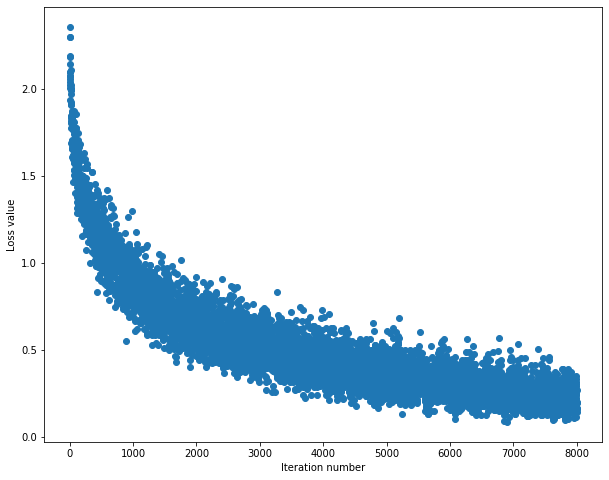

In [6]:
train_loader, val_loader, test_loader = get_data_loaders()

torch.manual_seed(0)
model = Net()
model = model.cuda()

num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # TODO: choose an optimizer

loss_history = []
for epoch in range(num_epochs):
  val_acc = eval_acc(model, val_loader)
  
  model.train()
  
  for batch, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    loss = model(images, labels)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
      loss_history.append(loss.item())
      if batch == 0:
        print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
          epoch, loss.item(), val_acc))

with torch.no_grad():
  plt.plot(loss_history, 'o')
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()

**result in 20 iteration**

In [7]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)
test_acc = eval_acc(model, test_loader)
print('Test Accuracy:', test_acc)

Training Accuracy: 96.7525
Validation Accuracy: 84.96
Test Accuracy: 85.03
